#Data Cleaning On 311 Service Requests from 2010 to present

Note : Recommended to Run on google colab(https://colab.research.google.com/) for Reproducibility.

###Installing packages

In [ ]:
!pip install pyspark

In [ ]:
!pip install openclean[full]

In [ ]:
!pip install pandas

In [ ]:
!pip install numpy

In [ ]:
!pip install humanfriendly

In [ ]:
!pip install -U -q PyDrive

###Loading Libraries

In [ ]:
# Loading Libraries
import pandas as pd
import numpy as np
from openclean.profiling.dataset import dataset_profile
from openclean.cluster.key import KeyCollision
from openclean.function.value.key.fingerprint import Fingerprint
from openclean.operator.map.violations import fd_violations
from openclean.operator.collector.count import distinct
from openclean.function.eval.logic import And
from openclean.function.value.phonetic import Soundex, soundex
from openclean.pipeline import stream
from openclean.data.load import dataset
from openclean.cluster.key import KeyCollision
from openclean_geo.address.usstreet import USStreetNameKey
from openclean_geo.address.usstreet import StandardizeUSStreetName
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit,col,when,udf,asc,regexp_replace,desc,countDistinct
from pyspark import SparkContext
import pyspark.sql.functions as f
from pyspark.sql.types import *
from pyspark.ml.feature import *
from openclean.profiling.column import DefaultColumnProfiler
from openclean.operator.map.violations import fd_violations
from openclean.operator.collector.count import distinct
import gzip
import humanfriendly
import os
import csv
from openclean.data.source.socrata import Socrata
from openclean.cluster.knn import knn_clusters, knn_collision_clusters
from openclean.function.similarity.base import SimilarityConstraint
from openclean.function.similarity.text import LevenshteinDistance
from openclean.function.value.threshold import GreaterThan
from openclean.function.value.null import is_empty
from openclean.operator.transform.update import update
from openclean.function.eval.base import Col, Eval
from openclean.function.eval.logic import And
from openclean.function.value.phonetic import Soundex, soundex
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import matplotlib.pyplot as plt
from pyspark.sql.window import Window

### Loading dataset 

Since Our dataset is of size 15 GB with 27.3 Million rows and 41 Column , We are having two approaches below to load dataset.

1. Sample Dataset - 750 MB and 1.3 Million rows ( Use this for Reproducibility testing and faster analysis)
2. Socrata Api    - Complete Dataset ( Uncomment code  only if running on spark cluster)

#### Downloading reference data files from Google Drive

Accept the google sdk T&C from any google account and paste the link and press enter

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
fileDownloaded = drive.CreateFile({'id':'1OMPb63gnxV3JRWNLeCWDbe1uB8l4_bBY'})
fileDownloaded.GetContentFile('nyc_zip_borough.csv')

In [ ]:
fileDownloaded = drive.CreateFile({'id':'1OMwBZPIM_Wy0n3QZzgA904TnX5Vv6Rq-'})
fileDownloaded.GetContentFile('Sampled_Data.csv')

#### Sample Dataset Loading

######Creating Spark Dataframe 

In [ ]:
spark = SparkSession.builder.appName("Project").getOrCreate()
sc = spark.sparkContext

In [ ]:
sc

<SparkContext master=local[*] appName=Project>

In [ ]:
df_data = spark.read.format("csv") \
.option("header", "true") \
.option("infer_schema","true")\
.option("first_row_is_header","true")\
.load("Sampled_Data.csv")

df_data.show()

+--------+----------+--------------------+--------------------+------+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-------------------+-----------------+---------------+---------------------+---------------------+------------+-------------------+--------+-------------+-------+--------------------+----------------------+------------------------------+--------------------+------------+-------------+--------------------------+--------------------------+----------------------+------------------+-------------+------------+--------------------+---------------------+-------------------+------------------------+---------+----------------------+------------------+------------------+--------------------+
|     _c0|Unique Key|        Created Date|         Closed Date|Agency|         Agency Name|      Complaint Type|          Descriptor|       Location Type|Incident Zip|    Incident Address|        Street Name|   Cross Street

In [ ]:
df_311= df_data.select('*')
df_311.show()

+--------+----------+--------------------+--------------------+------+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-------------------+-----------------+---------------+---------------------+---------------------+------------+-------------------+--------+-------------+-------+--------------------+----------------------+------------------------------+--------------------+------------+-------------+--------------------------+--------------------------+----------------------+------------------+-------------+------------+--------------------+---------------------+-------------------+------------------------+---------+----------------------+------------------+------------------+--------------------+
|     _c0|Unique Key|        Created Date|         Closed Date|Agency|         Agency Name|      Complaint Type|          Descriptor|       Location Type|Incident Zip|    Incident Address|        Street Name|   Cross Street

######Creating Data Stream 

In [ ]:
ds = stream('Sampled_Data.csv')

#### Complete Dataset Loading

Download file using Socrata API

In [ ]:
# dataset = Socrata().dataset('erm2-nwe9')
# datafile = './erm2-nwe9.tsv.gz'
# # Download file only if it does not exist already.
# if not os.path.isfile(datafile):
#     with gzip.open(datafile, 'wb') as f:
#       print('Downloading ...\n')
#       dataset.write(f)
# fsize = humanfriendly.format_size(os.stat(datafile).st_size)
# print("Using '{}' in file {} of size {}".format(dataset.name, datafile, fsize))

##### Creating Spark Dataframe

In [ ]:
# spark = SparkSession.builder.appName("Project").getOrCreate()
# sc = spark.sparkContext

In [ ]:
# sc

In [ ]:
# df_data = spark.read.format("csv") \
# .option("header", "true") \
# .option("infer_schema","true")\
# .option("first_row_is_header","true")\
# .load(datafile)

In [ ]:
# df_311= df_data.select('*')
# df_311.show()

##### Creating Data Stream

In [ ]:
# ds = stream(datafile)

### Initial Profiling

In [ ]:
profiles = ds.profile(default_profiler=DefaultColumnProfiler)
profiles.stats()

/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1212: UnknownTimezoneWarning: tzname PLACE identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


,total,empty,distinct,uniqueness,entropy
,1353465,0,1353465,1.000000,20.368226
Unique Key,1353465,0,1353465,1.000000,20.368226
Created Date,1353465,0,1142338,0.844010,19.440945
Closed Date,1353465,37626,939005,0.713617,18.714398
Agency,1353465,0,28,0.000021,2.949971
Agency Name,1353465,0,680,0.000502,3.336534
Complaint Type,1353465,0,316,0.000233,5.921032
Descriptor,1353465,21326,1484,0.001114,7.334426
Location Type,1353465,320891,171,0.000166,3.129963
Incident Zip,1353465,71169,823,0.000642,8.012380


In [ ]:
print(profiles.types())

                                   date   float      int     str
                                      0       0  1353465       0
Unique Key                            0       0  1353465       0
Created Date                    1142338       0        0       0
Closed Date                      939005       0        0       0
Agency                                0       0        0      28
Agency Name                           0       0        0     680
Complaint Type                        0       0        0     316
Descriptor                            0       0        0    1484
Location Type                         0       0        0     171
Incident Zip                          0     334      441      48
Incident Address                     60       0       23  429512
Street Name                           1       0       48   16039
Cross Street 1                        2       0        3   21357
Cross Street 2                        0       0        4   18131
Intersection Street 1    

In [ ]:
df_data.schema.names 

['_c0',
 'Unique Key',
 'Created Date',
 'Closed Date',
 'Agency',
 'Agency Name',
 'Complaint Type',
 'Descriptor',
 'Location Type',
 'Incident Zip',
 'Incident Address',
 'Street Name',
 'Cross Street 1',
 'Cross Street 2',
 'Intersection Street 1',
 'Intersection Street 2',
 'Address Type',
 'City',
 'Landmark',
 'Facility Type',
 'Status',
 'Due Date',
 'Resolution Description',
 'Resolution Action Updated Date',
 'Community Board',
 'BBL',
 'Borough',
 'X Coordinate (State Plane)',
 'Y Coordinate (State Plane)',
 'Open Data Channel Type',
 'Park Facility Name',
 'Park Borough',
 'Vehicle Type',
 'Taxi Company Borough',
 'Taxi Pick Up Location',
 'Bridge Highway Name',
 'Bridge Highway Direction',
 'Road Ramp',
 'Bridge Highway Segment',
 'Latitude',
 'Longitude',
 'Location']

###Initial Cleaning and Dimensionality Reduction



###### Drop Duplicate rows

In [ ]:
''' droping duplicate rows '''
df_311.dropDuplicates().show()

+--------+----------+--------------------+--------------------+------+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-----------------+---------------+---------------+---------------------+---------------------+------------+-----+--------+-------------+-------+--------------------+----------------------+------------------------------+-----------------+------------+-------+--------------------------+--------------------------+----------------------+------------------+------------+------------+--------------------+---------------------+-------------------+------------------------+---------+----------------------+-----------------+------------------+--------------------+
|     _c0|Unique Key|        Created Date|         Closed Date|Agency|         Agency Name|      Complaint Type|          Descriptor|       Location Type|Incident Zip|    Incident Address|      Street Name| Cross Street 1| Cross Street 2|Intersection S

######Making Null's Consistent across dataset

Data contains Unknown value not in in the form of Nan,nulls but also with values 'Unspecified' and 'UNKOWN' .
We are replacing this values with nulls to make sure it's consistent across dataset.

In [ ]:
''' Replace Unspecified and UNKOWN value with nulls'''
def replace(column, value):
    return when(column != value, column).otherwise(lit(None))

df_311 = df_311.withColumn("Park Facility Name", replace(col("Park Facility Name"), "Unspecified"))
df_311 = df_311.withColumn("Open Data Channel Type", replace(col("Open Data Channel Type"), "UNKNOWN"))

df_311.show()

+--------+----------+--------------------+--------------------+------+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-------------------+-----------------+---------------+---------------------+---------------------+------------+-------------------+--------+-------------+-------+--------------------+----------------------+------------------------------+--------------------+------------+-------------+--------------------------+--------------------------+----------------------+------------------+-------------+------------+--------------------+---------------------+-------------------+------------------------+---------+----------------------+------------------+------------------+--------------------+
|     _c0|Unique Key|        Created Date|         Closed Date|Agency|         Agency Name|      Complaint Type|          Descriptor|       Location Type|Incident Zip|    Incident Address|        Street Name|   Cross Street

######Dimensionality Reduction

As seen in profiling there are many column which has null or unspecifed values and hence will be of no use for future analysis . Hence we are removing the columns where more than 50% of data is null.

In [ ]:
''' Drop columns with more than 50% of rows being null'''

import pyspark.sql.functions as F
def drop_null_columns(df):
    """
    This function drops all columns which contain null values.
    :param df: A PySpark DataFrame
    """
    total_rows = df.count()
    null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0].asDict()
    to_drop = [k for k, v in null_counts.items() if v > (0.5*total_rows)]
    print('to_drop:{}'.format(to_drop))
    df = df.drop(*to_drop)
    return df

df_311= drop_null_columns(df_311)

to_drop:['Intersection Street 1', 'Intersection Street 2', 'Landmark', 'Facility Type', 'Due Date', 'Park Facility Name', 'Vehicle Type', 'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name', 'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment']


There are some duplicate columns like 

*   Location - Combination of Longitude and Latitude Columns
*   Park Borough - Same as Borough Column 

So we are removing this column as part of dimensionality reduction.

In [ ]:
''' Drop duplicate and unnecessary Columns'''

df_311=df_311.drop('Location')
df_311=df_311.drop('Park Borough')
df_311 = df_311.drop("_c0")

###Creating Spark SQL View

After the Dimensionality Reduction we now require to clean data according to respective Column and spark sql could be great use to analyze data.

In [ ]:
df_311.createOrReplaceTempView("df_311")


###Cleaning DATE Columns

In our dataset we have 3 Date Coloumns 
1.   Created Date
2.   Closed Date
3.   Resolution Action Updated Date


i. We remove all entries where the closed date, resolution action action date both are null and status is either closed or null

In [ ]:
df_311 = spark.sql("SELECT * FROM df_311 where `Closed Date` is not null and (status is not null or status!='Closed') and `Resolution Action Updated Date` is not null")

ii. We fill the missing closed date values based on the resolution action update date and vice versa

In [ ]:
df_311=df_311.withColumn("Closed Date", when((col("Closed Date").isNull()) & (col("Status")=='Closed') &(col("Resolution Action Updated Date").isNotNull()),col("Resolution Action Updated Date")).otherwise(col("Closed Date")))
df_311=df_311.withColumn("Resolution Action Updated Date", when((col("Resolution Action Updated Date").isNull()) & (col("Closed Date").isNotNull()),col("Closed Date")).otherwise(col("Resolution Action Updated Date")))

iii. Remove all entries where closed date < created date and created date > current date

In [ ]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df_311.createOrReplaceTempView("df_311_closed_date")
df_311=spark.sql("select * from df_311_closed_date where to_date(`closed date`,'MM/dd/yyyy')>=to_date(`created date`,'MM/dd/yyyy')")
df_311=spark.sql("select * from df_311_closed_date where to_date(`created date`,'MM/dd/yyyy')<=now() or to_date(`closed date`,'MM/dd/yyyy')<=now()")

### Cleaning AGENCY and AGENCY NAME Columns

In the Below outputs we find that **"MAYORâ\x80\x99S OFFICE OF SPECIAL ENFORCEMENT"** in agency should have been **"OSE"** as short form and **"Mayor's Special Office of Enforcement"** as complete Agency Name.



In [ ]:
df_311.select("Agency").distinct().show()

+--------------------+
|              Agency|
+--------------------+
|               NYCEM|
|MAYORâS OFFICE ...|
|                 DOT|
|                 HPD|
|                 DCA|
|                 DPR|
|                 TLC|
|                 EDC|
|                 DOF|
|               DORIS|
|               3-1-1|
|                NYPD|
|                 DOB|
|                DFTA|
|                 DEP|
|                 DOE|
|               DOHMH|
|                DSNY|
|                 DHS|
|               DOITT|
+--------------------+



In [ ]:
df_311.select("Agency Name").distinct().show()

+--------------------+
|         Agency Name|
+--------------------+
|      Exemption Unit|
|School - PS 200 B...|
|Department of Env...|
|        Manhattan 02|
|School - Metropol...|
|School - PS 199 J...|
|   Brooklyn South 10|
|School - PS 81 Th...|
|BCC - Brooklyn North|
|School - JHS 8 Ri...|
|       A - Manhattan|
|School - Fort Gre...|
|School - PS 116 E...|
|School - William ...|
|School - School f...|
|Economic Developm...|
|School - Stuyvesa...|
|Taxi and Limousin...|
|School - PS 50 Vi...|
|School - PS 105 S...|
+--------------------+
only showing top 20 rows



Below code makes the required changes

In [ ]:
df_311 = df_311.withColumn("Agency", when(df_311.Agency == 'MAYORâ\x80\x99S OFFICE OF SPECIAL ENFORCEMENT',"OSE").otherwise(df_311.Agency))
df_311 = df_311.withColumn("Agency Name",when(df_311["Agency Name"][0:6] == "Mayorâ", "Mayor's Special Office of Enforcement").otherwise(df_311["Agency Name"]))

These columns are now having consitent and clean data

In [ ]:
df_311.select("Agency", "Agency Name").filter(df_311["Agency"] == "OSE").show(20,False)

+------+-------------------------------------+
|Agency|Agency Name                          |
+------+-------------------------------------+
|OSE   |Mayor's Special Office of Enforcement|
|OSE   |Mayor's Special Office of Enforcement|
|OSE   |Mayor's Special Office of Enforcement|
|OSE   |Mayor's Special Office of Enforcement|
|OSE   |Mayor's Special Office of Enforcement|
|OSE   |Mayor's Special Office of Enforcement|
|OSE   |Mayor's Special Office of Enforcement|
|OSE   |Mayor's Special Office of Enforcement|
|OSE   |Mayor's Special Office of Enforcement|
|OSE   |Mayor's Special Office of Enforcement|
|OSE   |Mayor's Special Office of Enforcement|
|OSE   |Mayor's Special Office of Enforcement|
|OSE   |Mayor's Special Office of Enforcement|
|OSE   |Mayor's Special Office of Enforcement|
|OSE   |Mayor's Special Office of Enforcement|
|OSE   |Mayor's Special Office of Enforcement|
|OSE   |Mayor's Special Office of Enforcement|
|OSE   |Mayor's Special Office of Enforcement|
|OSE   |Mayor

Below we are Trying to check the Functional dependancy between Agency and Agency Name i.e, a single agency can have many Agency Name but Agency name only corresponds to single Agency. 
We do not find any conflicts so no more cleaning is required.

In [ ]:
df_311.groupBy("Agency Name").agg(countDistinct("Agency")).show(2000, False)

+-----------------------------------------------------------------------------------------+-------------+
|Agency Name                                                                              |count(Agency)|
+-----------------------------------------------------------------------------------------+-------------+
|Exemption Unit                                                                           |1            |
|School - PS 200 Benson School                                                            |1            |
|School - Aviation Career and Technical Education High School                             |1            |
|School - PS 118 Lorraine Hansberry                                                       |1            |
|School - August Martin High School                                                       |1            |
|School - PS 225 The Eileen E Zaglin                                                      |1            |
|School - Metropolitan Diploma Plus High Schoo

### Cleaning COMPLAINT TYPE Column

In [ ]:
df_311.groupBy("Complaint Type").count().sort(desc("count")).show(2000, False)

+-----------------------------------------+------+
|Complaint Type                           |count |
+-----------------------------------------+------+
|Noise - Residential                      |125956|
|HEAT/HOT WATER                           |77060 |
|Illegal Parking                          |68867 |
|Blocked Driveway                         |58143 |
|Street Condition                         |52708 |
|Street Light Condition                   |51016 |
|HEATING                                  |44207 |
|Noise - Street/Sidewalk                  |42563 |
|PLUMBING                                 |37712 |
|Water System                             |36400 |
|General Construction/Plumbing            |28130 |
|Noise                                    |27979 |
|UNSANITARY CONDITION                     |27890 |
|Traffic Signal Condition                 |24918 |
|GENERAL CONSTRUCTION                     |23639 |
|Noise - Commercial                       |21857 |
|Sewer                         

Visualization Before Cleaning

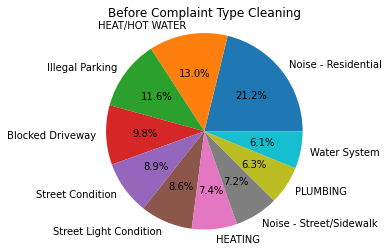

In [ ]:
ComType_counts = df_311.groupBy("Complaint Type").count().orderBy("count",ascending=False)
ComType_percentage = ComType_counts.withColumn("percent", f.col('count')*100/f.sum('count').over(Window.partitionBy())) 
ComType_percentage.orderBy('percent', ascending=False)
import matplotlib.pyplot as plt
counts = ComType_percentage.head(10)
indexes = list(range(len(counts)))
values = [r['percent'] for r in counts]
labels = [r['Complaint Type'] for r in counts]
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("Before Complaint Type Cleaning")
plt.axis('equal')
plt.show()

To make analysis easier we tried to group some of the above Complaint types in a single group for example in above output we have 

1.   Noise                                    
2.   Noise - Commercial                       
3.   Noise - Helicopter                       
4.   Noise - House of Worship                 
5.   Noise - Park                             
6.   Noise - Residential                      
7.   Noise - Street/Sidewalk                  
8.   Noise - Vehicle                          
9.   Noise Survey 

This all could be grouped under a single Complaint Type Noise

In [ ]:
df_311=df_311.withColumn("Complaint Type", regexp_replace(df_311["Complaint Type"],"Ferry.*","Ferry Complaint"))
df_311=df_311.withColumn("Complaint Type", regexp_replace(df_311["Complaint Type"],"Highway.*","Highway Complaint"))
df_311=df_311.withColumn("Complaint Type", regexp_replace(df_311["Complaint Type"],"Noise.*","Noise Complaint"))
df_311=df_311.withColumn("Complaint Type", regexp_replace(df_311["Complaint Type"],"Taxi.*","Taxi Complaint"))

We also find that there are some duplicate complaints like 
1.  Derelict Vehicle (10370) and Derelict Vehicles (13706)
2.  Animal-Abuse (875) and Animal Abuse (2740)
3.  PAINT - PLASTER (17827) and PAINT/PLASTER (20353)


We are using KNN cluster algorithm to group them and using the suggested word to replace and standardize it on whole dataset.



In [ ]:
complaint_type_dict= {}
cluster_dict ={}
def perform_knn_cluster(ds, column, using_collision=True, minsize=2, t=0.75):
    values = ds.select(column).distinct()
    clusters = knn_clusters(values=values, sim=SimilarityConstraint(func=LevenshteinDistance(), pred=GreaterThan(t)), minsize=minsize) \
        if using_collision else knn_collision_clusters(values=values, sim=SimilarityConstraint(func=LevenshteinDistance(), pred=GreaterThan(t)), minsize=minsize)
    print('{} clusters of size {} or greater'.format(len(clusters), minsize))
    clusters.sort(key=lambda c: len(c), reverse=True)
    for i, cluster in enumerate(clusters):
        print_cluster(i + 1, cluster)
        
def print_cluster(cnumber, cluster):
    print('Cluster {} (of size {})\n'.format(cnumber, len(cluster)))
    for val, count in cluster.items():
        print('{} ({})'.format(val, count))
        complaint_type_dict[val] = cnumber
    print('\nSuggested value: {}\n\n'.format(cluster.suggestion()))
    cluster_dict[cnumber] = cluster.suggestion()

perform_knn_cluster(ds,'Complaint Type')

18 clusters of size 2 or greater
Cluster 1 (of size 3)

DOF Property - Payment Issue (2655)
DOF Property - RPIE Issue (175)
DOF Property - Owner Issue (3129)

Suggested value: DOF Property - Owner Issue


Cluster 2 (of size 3)

OEM Literature Request (457)
DOR Literature Request (3)
HPD Literature Request (2611)

Suggested value: HPD Literature Request


Cluster 3 (of size 2)

DEP Street Condition (16)
Street Condition (54045)

Suggested value: Street Condition


Cluster 4 (of size 2)

Dirty Condition (412)
Dirty Conditions (20130)

Suggested value: Dirty Conditions


Cluster 5 (of size 2)

DEP Highway Condition (2)
Highway Condition (2490)

Suggested value: Highway Condition


Cluster 6 (of size 2)

DOF Property - Owner Issue (3129)
DOF Property - Payment Issue (2655)

Suggested value: DOF Property - Owner Issue


Cluster 7 (of size 2)

DOF Property - Owner Issue (3129)
DOF Property - RPIE Issue (175)

Suggested value: DOF Property - Owner Issue


Cluster 8 (of size 2)

Street Sign - 

In [ ]:
complaint_type_dict

{'Animal Abuse': 18,
 'Animal-Abuse': 18,
 'Commercial Disposal Complaint': 11,
 'DEP Highway Condition': 5,
 'DEP Street Condition': 3,
 'DOF Parking - Request Copy': 10,
 'DOF Parking - Request Status': 10,
 'DOF Property - Owner Issue': 7,
 'DOF Property - Payment Issue': 6,
 'DOF Property - RPIE Issue': 7,
 'DOR Literature Request': 2,
 'Derelict Vehicle': 13,
 'Derelict Vehicles': 13,
 'Dirty Condition': 4,
 'Dirty Conditions': 4,
 'FHV Licensee Complaint': 12,
 'HPD Literature Request': 2,
 'Highway Condition': 5,
 'Highway Sign - Dangling': 17,
 'Highway Sign - Missing': 17,
 'Illegal Parking': 9,
 'Illegal Posting': 9,
 'Litter Basket / Request': 15,
 'Litter Basket Request': 15,
 'OEM Literature Request': 2,
 'PAINT - PLASTER': 16,
 'PAINT/PLASTER': 16,
 'Residential Disposal Complaint': 11,
 'Street Condition': 3,
 'Street Sign - Dangling': 8,
 'Street Sign - Missing': 8,
 'Taxi Complaint': 14,
 'Taxi Compliment': 14,
 'Taxi Licensee Complaint': 12}

In [ ]:
cluster_dict

{1: 'DOF Property - Owner Issue',
 2: 'HPD Literature Request',
 3: 'Street Condition',
 4: 'Dirty Conditions',
 5: 'Highway Condition',
 6: 'DOF Property - Owner Issue',
 7: 'DOF Property - Owner Issue',
 8: 'Street Sign - Missing',
 9: 'Illegal Parking',
 10: 'DOF Parking - Request Status',
 11: 'Residential Disposal Complaint',
 12: 'FHV Licensee Complaint',
 13: 'Derelict Vehicles',
 14: 'Taxi Complaint',
 15: 'Litter Basket / Request',
 16: 'PAINT/PLASTER',
 17: 'Highway Sign - Missing',
 18: 'Animal Abuse'}

UDF to update Complaint Type

In [ ]:
@udf
def update_complaint_type(complaint):
    if complaint in complaint_type_dict:
      return cluster_dict[complaint_type_dict[complaint]]
    return complaint

df_311= df_311.withColumnRenamed("Complaint Type","Complaint_Type")
df_311= df_311.withColumn("Complaint_Type", update_complaint_type(df_311.Complaint_Type))

Result

In [ ]:
df_311.groupBy("Complaint_Type").count().sort(desc("count")).show(2000, False)

+-----------------------------------------+------+
|Complaint_Type                           |count |
+-----------------------------------------+------+
|Noise Complaint                          |241575|
|HEAT/HOT WATER                           |77060 |
|Illegal Parking                          |68881 |
|Blocked Driveway                         |58143 |
|Street Condition                         |52723 |
|Street Light Condition                   |51016 |
|HEATING                                  |44207 |
|PLUMBING                                 |37712 |
|PAINT/PLASTER                            |37099 |
|Water System                             |36400 |
|General Construction/Plumbing            |28130 |
|UNSANITARY CONDITION                     |27890 |
|Traffic Signal Condition                 |24918 |
|Derelict Vehicles                        |24021 |
|GENERAL CONSTRUCTION                     |23639 |
|Sewer                                    |20790 |
|Dirty Conditions              

Visualization After Cleaning

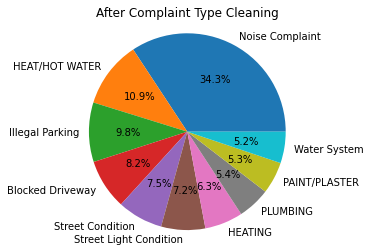

In [ ]:
ComTypea_counts = df_311.groupBy("Complaint_Type").count().orderBy("count",ascending=False)
ComTypea_percentage = ComTypea_counts.withColumn("percent", f.col('count')*100/f.sum('count').over(Window.partitionBy())) 
ComTypea_percentage.orderBy('percent', ascending=False)
import matplotlib.pyplot as plt
counts = ComTypea_percentage.head(10)
indexes = list(range(len(counts)))
values = [r['percent'] for r in counts]
labels = [r['Complaint_Type'] for r in counts]
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("After Complaint Type Cleaning")
plt.axis('equal')
plt.show()

### Cleaning INCIDENT ZIP Column

Remove all null rows

In [ ]:
df_311.na.drop(subset=["Incident Zip"]).show()

+----------+--------------------+--------------------+------+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-------------------+-----------------+---------------+------------+-------------------+-------+----------------------+------------------------------+-----------------+------------+-------------+--------------------------+--------------------------+----------------------+------------------+------------------+
|Unique Key|        Created Date|         Closed Date|Agency|         Agency Name|      Complaint_Type|          Descriptor|       Location Type|Incident Zip|    Incident Address|        Street Name|   Cross Street 1| Cross Street 2|Address Type|               City| Status|Resolution Description|Resolution Action Updated Date|  Community Board|         BBL|      Borough|X Coordinate (State Plane)|Y Coordinate (State Plane)|Open Data Channel Type|          Latitude|         Longitude|
+----------+----------

Visualization Before Cleaning

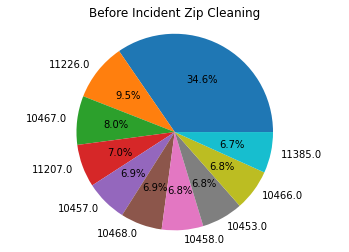

In [ ]:
incidentZip_counts = df_311.groupBy("Incident Zip").count().orderBy("count",ascending=False)
incidentZip_percentage = incidentZip_counts.withColumn("percent", f.col('count')*100/f.sum('count').over(Window.partitionBy())) 
incidentZip_percentage.orderBy('percent', ascending=False)
counts = incidentZip_percentage.head(10)
indexes = list(range(len(counts)))
values = [r['percent'] for r in counts]
labels = [r['Incident Zip'] for r in counts]
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("Before Incident Zip Cleaning")
plt.axis('equal')
plt.show()

Having a look at values of Zip we find many values to be either decimal, alphanumeric or inconsistent length.

In [ ]:
df_311=df_311.withColumnRenamed("Incident Zip","Incident_Zip")
df_311.select("Incident_Zip").distinct().show(50)

+------------+
|Incident_Zip|
+------------+
|       91910|
|     10475.0|
|       11236|
|       11205|
|       10309|
|     10278.0|
|       11106|
|       10801|
|       11251|
|     11207.0|
|     10036.0|
|     11420.0|
|       11218|
|     10307.0|
|     10103.0|
|     11590.0|
|       11137|
|       10452|
|     10075.0|
|     10471.0|
|     49503.0|
|     10301.0|
|       18504|
|     10452.0|
|       11428|
|       10169|
|     11367.0|
|       11237|
|     11222.0|
|     11356.0|
|       11379|
|       11021|
|     11241.0|
|       11756|
|     11230.0|
|     11694.0|
|     10129.0|
|     11428.0|
|     11102.0|
|     10173.0|
|     10019.0|
|       11364|
|     10029.0|
|     11366.0|
|       11109|
|     10179.0|
|       22408|
|       11249|
|     10111.0|
|     11232.0|
+------------+
only showing top 50 rows



Standardizing zip codes to length = 5 and only replacing values if numeric.

In [ ]:
@udf
def fill(zip_code):
    ''' Function takin zip code as input
        checks if zip code is numeric and has 5 digits 
        returns formated zip code or "" 
    '''
    zip_code = str(zip_code).zfill(5)
    if not zip_code.isnumeric() :
      return " "
    return zip_code[:5]

df_311= df_311.withColumn("Incident_Zip", fill(df_311.Incident_Zip))

Removing nulls and empty (" ") zip codes from dataset and since new york zip code ranges from 10001 - 11697 remove any zip code not in this range.

In [ ]:
df_311.createOrReplaceTempView("df_311_incident_zip")
df_311= spark.sql('Select * FROM df_311_incident_zip  WHERE Incident_Zip IS NOT NULL AND Incident_Zip <> " " AND CAST(Incident_Zip AS int)> 10000 AND CAST(Incident_Zip as int) <= 11697 ')     

Result

In [ ]:
df_311.select('Incident_Zip').distinct().orderBy(col('Incident_Zip').desc()).show()

+------------+
|Incident_Zip|
+------------+
|       11697|
|       11695|
|       11694|
|       11693|
|       11692|
|       11691|
|       11646|
|       11598|
|       11590|
|       11581|
|       11580|
|       11577|
|       11570|
|       11566|
|       11563|
|       11561|
|       11560|
|       11559|
|       11558|
|       11557|
+------------+
only showing top 20 rows



Visualization After Cleaning

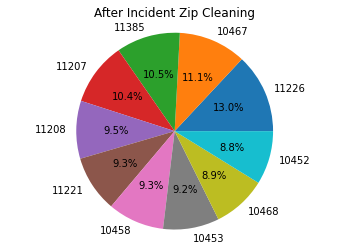

In [ ]:
incidentZipa_counts = df_311.groupBy("Incident_Zip").count().orderBy("count",ascending=False)
incidentZipa_percentage = incidentZipa_counts.withColumn("percent", f.col('count')*100/f.sum('count').over(Window.partitionBy())) 
incidentZipa_percentage.orderBy('percent', ascending=False)
counts = incidentZipa_percentage.head(10)
indexes = list(range(len(counts)))
values = [r['percent'] for r in counts]
labels = [r['Incident_Zip'] for r in counts]
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("After Incident Zip Cleaning")
plt.axis('equal')
plt.show()

### Cleaning CITY Column

We find that the CASE of city names is inconsistent as seen in below output we have 


1.   Corona and CORONA
2.   Bayside and BAYSIDE



In [ ]:
df_311.select("City").distinct().show()

+---------------+
|           City|
+---------------+
|         Corona|
|  VALLEY STREAM|
|      Rego Park|
|         CORONA|
|        Bayside|
|Jackson Heights|
|   WHITE PLAINS|
|        BAYSIDE|
|       MANHATAN|
|Oakland Gardens|
|    Little Neck|
|       Flushing|
|   FAR ROCKAWAY|
|    KEW GARDENS|
|  East Elmhurst|
|    FLORAL PARK|
|     Whitestone|
|           null|
|        HEWLETT|
|      Glen Oaks|
+---------------+
only showing top 20 rows



Visualization Before Cleaning

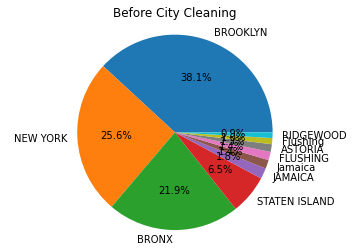

In [ ]:
city_counts = df_311.groupBy("City").count().orderBy("count",ascending=False)
city_percentage = city_counts.withColumn("percent", f.col('count')*100/f.sum('count').over(Window.partitionBy())) 
city_percentage.orderBy('percent', ascending=False)
import matplotlib.pyplot as plt
counts = city_percentage.head(10)
indexes = list(range(len(counts)))
values = [r['percent'] for r in counts]
labels = [r['City'] for r in counts]
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("Before City Cleaning")
plt.axis('equal')
plt.show()

We are normalizing the case and making sure city does not has numeric values

In [ ]:
@udf
def standardize(city_name):
  ''' takes city names as input and output in Init caps form if valid city name '''
  standard_city_name = str(city_name).strip().capitalize()
  if standard_city_name.isnumeric():
    return None
  return standard_city_name

df_311= df_311.withColumn("City", standardize(df_311.City))

Result

In [ ]:
df_311.select("City").distinct().show()

+-------------------+
|               City|
+-------------------+
|             Corona|
|             Queens|
|            Bayside|
|       Forest hills|
|       New rochelle|
|               None|
|           Manhatan|
|           New york|
|      Valley stream|
|Springfield gardens|
|           Flushing|
|        North hills|
|      Rockaway park|
|    Port washington|
|   South ozone park|
|             Elmont|
|         Whitestone|
|        Floral park|
|            Hewlett|
|         Great neck|
+-------------------+
only showing top 20 rows



As a part of initial cleaning of some mispelled city names like Newarkk,BRKLYN.
We started with intial startegy of soundex but to our surprise some city names like newark has sam soundex of New York and this would make data rigged.

In [ ]:
newyork = ds\
    .select('City')\
    .update('City', str.upper)\
    .filter(And(Eval('City', Soundex()) == soundex('NEW YORK'), Col('City') != 'NEW YORK'))\
    .distinct()


As you see Newarkk soundex ranks highest for 'New York'

In [ ]:
print('RANK\tCOUNT\tNAME')
for i, entry in enumerate(newyork.most_common()):
    key, count = entry
    print('{}.\t{}\t{}'.format(i + 1, count, key))

RANK	COUNT	NAME
1.	52	NEWARK
2.	1	NEWARKK


Using Functional Dependency b/w City and Zip code to clean city column

Running the code below we find that a single zip code actually has mutiple city values or missing values which is incorrect.

In [ ]:
df_311.createOrReplaceTempView("df_311_city")
temp = spark.sql('Select Incident_Zip,CITY,Count(*) FROM df_311_city GROUP BY Incident_Zip,City Order by 1 ASC,3 DESC')
temp.show()

+------------+---------+--------+
|Incident_Zip|     CITY|count(1)|
+------------+---------+--------+
|       10001| New york|    1562|
|       10001|     None|      12|
|       10002| New york|    2721|
|       10002|     None|       2|
|       10002|Manhattan|       2|
|       10003| New york|    2476|
|       10003|     None|       3|
|       10003|   Elmont|       1|
|       10004| New york|     273|
|       10004|  Jamaica|       2|
|       10004|     None|       1|
|       10004|Manhattan|       1|
|       10005| New york|     323|
|       10005|     None|       2|
|       10006| New york|     196|
|       10007| New york|     488|
|       10009| New york|    2222|
|       10009|     None|      11|
|       10010| New york|    1039|
|       10010|     None|       4|
+------------+---------+--------+
only showing top 20 rows



A simple zip code example with multiple values

In [ ]:
temp = spark.sql('Select Incident_Zip,City,COUNT(*) FROM df_311_city  WHERE Incident_Zip="11368" Group by Incident_Zip,City Order by 3 DESC ') 
temp.distinct().show()

+------------+---------+--------+
|Incident_Zip|     City|count(1)|
+------------+---------+--------+
|       11368|  Maspeth|       2|
|       11368|Rego park|       1|
|       11368|   Corona|    2597|
|       11368| Flushing|       5|
|       11368|   Queens|       2|
|       11368|     None|       7|
|       11368|    Bronx|       1|
+------------+---------+--------+



Since we did not find any open or free dataset which could be used as a lookup for mapping city with zip code, We are trying to make use of our own strategy and assumption which you will also find mostcommon across our other cleaning techniques. 

As you can see above the frequency of Corona is higher than any other city for zip code 11368 and which is actually the correct mapping. Our assumption is that most of the data is correct and correct values are higher than incorrect values. So our strategy finds out the highest occuring values and replaces all the invalid or low occuring values with highest occuring values.


In [ ]:
''' creating ranks based on counts of each city for particular zip code '''
ranked_by_zip_city= spark.sql(" Select Incident_Zip, City ,COUNT(*),ROW_NUMBER() OVER(PARTITION BY Incident_Zip ORDER BY COUNT(*) DESC,Incident_Zip DESC) as rnk FROM df_311_city WHERE Incident_Zip IS NOT NULL GROUP BY Incident_Zip, City ORDER BY 1 ASC,3 DESC ") 
ranked_by_zip_city.show()

+------------+---------+--------+---+
|Incident_Zip|     City|count(1)|rnk|
+------------+---------+--------+---+
|       10001| New york|    1562|  1|
|       10001|     None|      12|  2|
|       10002| New york|    2721|  1|
|       10002|     None|       2|  2|
|       10002|Manhattan|       2|  3|
|       10003| New york|    2476|  1|
|       10003|     None|       3|  2|
|       10003|   Elmont|       1|  3|
|       10004| New york|     273|  1|
|       10004|  Jamaica|       2|  2|
|       10004|     None|       1|  4|
|       10004|Manhattan|       1|  3|
|       10005| New york|     323|  1|
|       10005|     None|       2|  2|
|       10006| New york|     196|  1|
|       10007| New york|     488|  1|
|       10009| New york|    2222|  1|
|       10009|     None|      11|  2|
|       10010| New york|    1039|  1|
|       10010|     None|       4|  2|
+------------+---------+--------+---+
only showing top 20 rows



Getting the top ranked(most frequent) city name for each zip code and creating a dictionary with key as zip and value as most frequent city.  

In [ ]:
ranked_by_zip_city.createOrReplaceTempView("ranked_by_zip_city")
top_ranked = spark.sql(" SELECT Incident_Zip,City FROM ranked_by_zip_city WHERE rnk =1 ")

data_itr = top_ranked.rdd.toLocalIterator()
zip_dicti = {}
for row in data_itr:
    zip_dicti[row["Incident_Zip"]] = row["City"]

Updating the spark dataframe using the dictionary.

In [ ]:
@udf

def update_city(zip_code):
  ''' takes input as zip code and outputs the city the zip code refers to '''
  if zip_code in zip_dicti:
      return zip_dicti[zip_code]
  return " " 

df_311 =df_311.withColumn("City", update_city(df_311.Incident_Zip))
df_311.show()

+----------+--------------------+--------------------+------+--------------------+--------------------+--------------------+--------------------+------------+--------------------+----------------+---------------+------------------+------------+-------------------+------+----------------------+------------------------------+-----------------+------------+-----------+--------------------------+--------------------------+----------------------+------------------+------------------+
|Unique Key|        Created Date|         Closed Date|Agency|         Agency Name|      Complaint_Type|          Descriptor|       Location Type|Incident_Zip|    Incident Address|     Street Name| Cross Street 1|    Cross Street 2|Address Type|               City|Status|Resolution Description|Resolution Action Updated Date|  Community Board|         BBL|    Borough|X Coordinate (State Plane)|Y Coordinate (State Plane)|Open Data Channel Type|          Latitude|         Longitude|
+----------+--------------------

Result

In [ ]:
df_311.createOrReplaceTempView('df_311_zip')
temp = spark.sql('Select Incident_Zip,City FROM df_311_zip  WHERE Incident_Zip="11368"') 
temp.distinct().show()

+------------+------+
|Incident_Zip|  City|
+------------+------+
|       11368|Corona|
+------------+------+



In [ ]:
df_311.select("City").distinct().orderBy("City").show(100)

+-------------------+
|               City|
+-------------------+
|            Arverne|
|            Astoria|
|            Baldwin|
|            Bayside|
|            Bedford|
|          Bellerose|
|       Breezy point|
|              Bronx|
|         Bronxville|
|           Brooklyn|
|            Buffalo|
|    Cambria heights|
|      College point|
|             Corona|
|        Dobbs ferry|
|      East elmhurst|
|           Elmhurst|
|             Elmont|
|       Far rockaway|
|        Floral park|
|            Florida|
|           Flushing|
|       Forest hills|
|    Franklin square|
|      Fresh meadows|
|        Garden city|
|          Glen oaks|
|        Glenhead ny|
|         Great neck|
|     Greenwood lake|
|          Hawthorne|
|          Hempstead|
|            Hewlett|
|      Highland park|
|             Hollis|
|       Howard beach|
|    Jackson heights|
|            Jamaica|
|        Kew gardens|
|              Kisco|
|       Lake success|
|           Lawrence|
|        L

Visualization After Cleaning

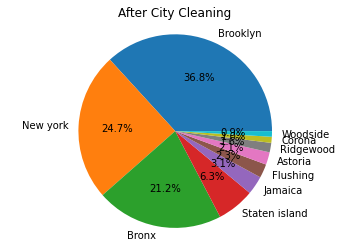

In [ ]:
citya_counts = df_311.groupBy("City").count().orderBy("count",ascending=False)
citya_percentage = citya_counts.withColumn("percent", f.col('count')*100/f.sum('count').over(Window.partitionBy())) 
citya_percentage.orderBy('percent', ascending=False)
import matplotlib.pyplot as plt
counts = citya_percentage.head(10)
indexes = list(range(len(counts)))
values = [r['percent'] for r in counts]
labels = [r['City'] for r in counts]
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("After City Cleaning")
plt.axis('equal')
plt.show()

### Cleaning Borough Column

Data is preceeded with numeric and followed by Borough

In [ ]:
df_311.select("Borough").distinct().show()

+-------------+
|      Borough|
+-------------+
|  06 BROOKLYN|
|  Unspecified|
|       QUEENS|
|     BROOKLYN|
|        BRONX|
| 04 MANHATTAN|
|    MANHATTAN|
|STATEN ISLAND|
|  07 BROOKLYN|
|     12 BRONX|
|  12 BROOKLYN|
| 02 MANHATTAN|
+-------------+



Visualization Before cleaning

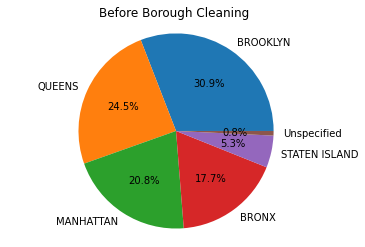

In [ ]:
borough_counts = df_311.groupBy("Borough").count().orderBy("count",ascending=False)
borough_percentage = borough_counts.withColumn("percent", f.col('count')*100/f.sum('count').over(Window.partitionBy())) 
borough_percentage.orderBy('percent', ascending=False)
import matplotlib.pyplot as plt
counts = borough_percentage.head(6)
indexes = list(range(len(counts)))
values = [r['percent'] for r in counts]
labels = [r['Borough'] for r in counts]
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("Before Borough Cleaning")
plt.axis('equal')
plt.show()

We also find some unspecified and null values which can be filled with functional dependancy b/w zip and borough.

In [ ]:
temp = spark.sql('Select Incident_Zip,Borough FROM df_311_zip  WHERE Incident_Zip="10452"') 
temp.distinct().show()

+------------+-----------+
|Incident_Zip|    Borough|
+------------+-----------+
|       10452|      BRONX|
|       10452|Unspecified|
+------------+-----------+



In order to clean the numeric and standardize the data we are using a lookup file which has maping between zip and borough.

In [ ]:
#using nyc_zip_borough.csv loading master data for lookup

boro_df = pd.read_csv("nyc_zip_borough.csv")

boro_dict ={}
for _, row in boro_df.iterrows():
    boro_dict[str(row['zip'])] = str(row['borough'])

print(boro_dict)

{'10001': 'Manhattan', '10002': 'Manhattan', '10003': 'Manhattan', '10004': 'Manhattan', '10005': 'Manhattan', '10006': 'Manhattan', '10007': 'Manhattan', '10009': 'Manhattan', '10010': 'Manhattan', '10011': 'Manhattan', '10012': 'Manhattan', '10013': 'Manhattan', '10014': 'Manhattan', '10016': 'Manhattan', '10017': 'Manhattan', '10018': 'Manhattan', '10019': 'Manhattan', '10021': 'Manhattan', '10022': 'Manhattan', '10023': 'Manhattan', '10024': 'Manhattan', '10025': 'Manhattan', '10026': 'Manhattan', '10027': 'Manhattan', '10028': 'Manhattan', '10029': 'Manhattan', '10030': 'Manhattan', '10031': 'Manhattan', '10032': 'Manhattan', '10033': 'Manhattan', '10034': 'Manhattan', '10035': 'Manhattan', '10036': 'Manhattan', '10037': 'Manhattan', '10038': 'Manhattan', '10039': 'Manhattan', '10040': 'Manhattan', '10044': 'Manhattan', '10065': 'Manhattan', '10069': 'Manhattan', '10075': 'Manhattan', '10128': 'Manhattan', '10280': 'Manhattan', '10282': 'Manhattan', '10301': 'Staten Island', '1030

UDF (User Defined function) to update borough based on above dictionary

In [ ]:
@udf
def update_boro(zip_code):
  '''takes zip_code as input and outputs appropriate Borough'''
  if zip_code in boro_dict:
      return boro_dict[zip_code]
  return " " 
df_311 =df_311.withColumn("Borough", update_boro(df_311.Incident_Zip))
df_311.select("Incident_Zip","Borough").show()

+------------+---------+
|Incident_Zip|  Borough|
+------------+---------+
|       10457|    Bronx|
|       10009|Manhattan|
|       11691|   Queens|
|       11219| Brooklyn|
|       11374|   Queens|
|       11226| Brooklyn|
|       11413|   Queens|
|       11419|   Queens|
|       11385|   Queens|
|       11236| Brooklyn|
|       11221| Brooklyn|
|       10026|Manhattan|
|       11385|   Queens|
|       11204| Brooklyn|
|       10033|Manhattan|
|       11203| Brooklyn|
|       11226| Brooklyn|
|       11208| Brooklyn|
|       10013|Manhattan|
|       11104|   Queens|
+------------+---------+
only showing top 20 rows



Result

In [ ]:
df_311.createOrReplaceTempView("df_311_boro")
temp = spark.sql('Select Incident_Zip,Borough FROM df_311_boro WHERE Incident_Zip="10452"') 
temp.distinct().show()

+------------+-------+
|Incident_Zip|Borough|
+------------+-------+
|       10452|  Bronx|
+------------+-------+



We find Borough with "" because our look data only had "Queens","Brooklyn","Staten Island","Manhattan","Bronx" as bourgh but our dataset also has king county and other boroughs so we are going to filter them out.

In [ ]:
df_311.select('Borough').distinct().show()

+-------------+
|      Borough|
+-------------+
|       Queens|
|     Brooklyn|
|Staten Island|
|             |
|    Manhattan|
|        Bronx|
+-------------+



In [ ]:
li =["Queens","Brooklyn","Staten Island","Manhattan","Bronx"]
df_311=df_311.filter(df_311.Borough.isin(li))
df_311.select('Borough').distinct().show()

+-------------+
|      Borough|
+-------------+
|       Queens|
|     Brooklyn|
|Staten Island|
|    Manhattan|
|        Bronx|
+-------------+



Visualization after Cleaning

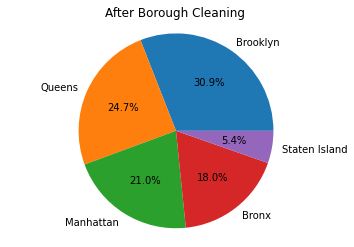

In [ ]:
borougha_counts = df_311.groupBy("Borough").count().orderBy("count",ascending=False)
borougha_percentage = borougha_counts.withColumn("percent", f.col('count')*100/f.sum('count').over(Window.partitionBy())) 
borougha_percentage.orderBy('percent', ascending=False)
import matplotlib.pyplot as plt
counts = borougha_percentage.head(6)
indexes = list(range(len(counts)))
values = [r['percent'] for r in counts]
labels = [r['Borough'] for r in counts]
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("After Borough Cleaning")
plt.axis('equal')
plt.show()

###Cleaning INCIDENT_ADRESS , STREET ADDRESS, CROSS STREET 1, CROSS STREET 2

#### Incident Address

We are using Key Collison Clustering with default fingerprint key generator for all address types

In [ ]:
incident_address = ds.update('Incident Address', str.upper).distinct('Incident Address')
clusters = KeyCollision(func=Fingerprint()).clusters(incident_address)

Based on the clusters created we are also generating 2  additonal dictionaries i.e, incident_address_dict and cluster_dict

In [ ]:
incident_address_dict = {}
cluster_dict = {}
def print_k_clusters(clusters):
    clusters = sorted(clusters, key=lambda x: len(x), reverse=True)
    # val_count = sum([len(c) for c in clusters])
    # print('Total number of clusters is {} with {} values'.format(len(clusters), val_count))
    for i in range(len(clusters)):
        print('\nCluster {}'.format(i + 1))
        temp_dict = {}
        for key, cnt in clusters[i].items():
          if key == '':
            key = "''"
          print(f'  {key} (x {cnt})')
          temp_dict[key] = int(cnt)
          cluster_dict[key] = i

        incident_address_dict[i] = temp_dict 
print_k_clusters(clusters)   

Streaming output truncated to the last 5000 lines.

Cluster 18369
  4915 BROADWAY (x 30)
  49-15 BROADWAY (x 2)

Cluster 18370
  493 EAST 93 STREET (x 1)
  493 EAST   93 STREET (x 1)

Cluster 18371
  494 EAST   96 STREET (x 2)
  494 EAST 96 STREET (x 2)

Cluster 18372
  495 EAST 95 STREET (x 2)
  495 EAST   95 STREET (x 1)

Cluster 18373
  497 EAST 93 STREET (x 5)
  497 EAST   93 STREET (x 1)

Cluster 18374
  499 EAST    8 STREET (x 7)
  499 EAST 8 STREET (x 9)

Cluster 18375
  499 EAST 94 STREET (x 5)
  499 EAST   94 STREET (x 1)

Cluster 18376
  50 EAST    5 STREET (x 1)
  5 EAST   50 STREET (x 1)

Cluster 18377
  50 NORTH 5 STREET (x 3)
  50 NORTH    5 STREET (x 3)

Cluster 18378
  502 EAST    5 STREET (x 3)
  502 EAST 5 STREET (x 1)

Cluster 18379
  504 EAST 5 STREET (x 3)
  504 EAST    5 STREET (x 1)

Cluster 18380
  506 EAST 5 STREET (x 1)
  506 EAST    5 STREET (x 1)

Cluster 18381
  507 EAST 5 STREET (x 2)
  507 EAST    5 STREET (x 2)

Cluster 18382
  509 EAST 5 STREET (x 2)
  

Incident_address_dict contains a mapping of structure { cluster_number : {street : number of time it got repeated }}

In [ ]:
incident_address_dict 

{0: {'140 WEST  140 STREET': 10,
  '140 WEST 140 STREET': 2,
  '140 WEST STREET': 10,
  '140 WEST WEST 140 STREET': 1,
  'WEST  140 STREET': 1,
  'WEST 140 STREET': 7},
 1: {'12 WEST   12 STREET': 2,
  '12 WEST 12 STREET': 1,
  '12 WEST WEST 12 STREET': 1,
  'WEST   12 STREET': 16,
  'WEST 12 STREET': 7},
 2: {'120 WEST  120 STREET': 1,
  '120 WEST 120 STREET': 67,
  '120 WEST STREET': 2,
  'WEST  120 STREET': 5,
  'WEST 120 STREET': 28},
 3: {'124 WEST  124 STREET': 1,
  '124 WEST 124 STREET': 1,
  '124 WEST STREET': 1,
  'WEST  124 STREET': 5,
  'WEST 124 STREET': 3},
 4: {'14 WEST   14 STREET': 2,
  '14 WEST 14 STREET': 1,
  '14 WEST STREET': 2,
  'WEST   14 STREET': 10,
  'WEST 14 STREET': 22},
 5: {'144 WEST  144 STREET': 5,
  '144 WEST 144 STREET': 10,
  '144 WEST STREET': 2,
  'WEST  144 STREET': 5,
  'WEST 144 STREET': 5},
 6: {'145 WEST  145 STREET': 2,
  '145 WEST 145 STREET': 2,
  '145 WEST STREET': 5,
  'WEST  145 STREET': 4,
  'WEST 145 STREET': 12},
 7: {'16 EAST  205 STR

Cluster dict is a simple dictionary which maps each street to repsective cluster.

In [ ]:
cluster_dict

{'140 WEST  140 STREET': 0,
 'WEST 140 STREET': 0,
 'WEST  140 STREET': 0,
 '140 WEST STREET': 0,
 '140 WEST 140 STREET': 0,
 '140 WEST WEST 140 STREET': 0,
 'WEST   12 STREET': 1,
 '12 WEST WEST 12 STREET': 1,
 'WEST 12 STREET': 1,
 '12 WEST 12 STREET': 1,
 '12 WEST   12 STREET': 1,
 '120 WEST 120 STREET': 2,
 'WEST  120 STREET': 2,
 'WEST 120 STREET': 2,
 '120 WEST  120 STREET': 2,
 '120 WEST STREET': 2,
 'WEST  124 STREET': 3,
 '124 WEST STREET': 3,
 'WEST 124 STREET': 3,
 '124 WEST  124 STREET': 3,
 '124 WEST 124 STREET': 3,
 'WEST 14 STREET': 4,
 'WEST   14 STREET': 4,
 '14 WEST 14 STREET': 4,
 '14 WEST STREET': 4,
 '14 WEST   14 STREET': 4,
 'WEST 144 STREET': 5,
 '144 WEST  144 STREET': 5,
 '144 WEST 144 STREET': 5,
 '144 WEST STREET': 5,
 'WEST  144 STREET': 5,
 'WEST 145 STREET': 6,
 '145 WEST STREET': 6,
 '145 WEST 145 STREET': 6,
 '145 WEST  145 STREET': 6,
 'WEST  145 STREET': 6,
 '205 EAST   16 STREET': 7,
 '16 EAST 205 STREET': 7,
 '16 EAST  205 STREET': 7,
 '205 EAST 16 

Using the same most frequent strategy we are creating a dictionary from incident_address_dict with key as cluster number and value as most frequent street for that cluster.

In [ ]:
final_addr = {}
for key,value in incident_address_dict.items():
    final_addr[key] = max(value, key=value.get)

print(final_addr)

{0: '140 WEST  140 STREET', 1: 'WEST   12 STREET', 2: '120 WEST 120 STREET', 3: 'WEST  124 STREET', 4: 'WEST 14 STREET', 5: '144 WEST 144 STREET', 6: 'WEST 145 STREET', 7: '205 EAST   16 STREET', 8: 'WEST 16 STREET', 9: 'WEST  161 STREET', 10: '20 WEST 47 STREET', 11: 'WEST 25 STREET', 12: 'WEST 27 STREET', 13: 'WEST 32 STREET', 14: 'EAST   36 STREET', 15: 'WEST 40 STREET', 16: 'WEST   45 STREET', 17: 'WEST   50 STREET', 18: 'WEST 56 STREET', 19: 'WEST 57 STREET', 20: '62 WEST 62 STREET', 21: 'WEST 71 STREET', 22: '1 EAST 33 STREET', 23: '43 EAST 1 STREET', 24: 'EAST 1 STREET', 25: '1 WEST STREET', 26: '10 EAST  125 STREET', 27: '10 WEST  135 STREET', 28: '10 WEST  195 STREET', 29: '10 EAST   23 STREET', 30: '10 EAST   28 STREET', 31: '10 EAST   29 STREET', 32: '30 EAST 10 STREET', 33: '10 EAST 43 STREET', 34: '10 BRIGHTON COURT', 35: 'WEST 10 STREET', 36: '111 EAST  100 STREET', 37: '55 WEST 100 STREET', 38: '101 WEST   12 STREET', 39: '169 EAST  101 STREET', 40: '101 EAST 179 STREET'

UDF to update Incident address 

In [ ]:
@udf
def update_incident_address(incident_address):
    if incident_address in cluster_dict:
      return final_addr[cluster_dict[incident_address]]
    return " "

df_311= df_311.withColumnRenamed("Incident Address","Incident_Address")
df_311= df_311.withColumn("Incident_Address", update_incident_address(df_311.Incident_Address))



Positive Case Result

In [ ]:
df_311.createOrReplaceTempView("df_data_address")
temp= spark.sql('Select * FROM df_data_address  WHERE Incident_Address =  "WEST 27 STREET" ')  
temp.show()

+----------+--------------------+--------------------+------+--------------------+--------------------+--------------------+---------------+------------+----------------+--------------+--------------+--------------+------------+--------+------+----------------------+------------------------------+---------------+------------+---------+--------------------------+--------------------------+----------------------+-----------------+------------------+
|Unique Key|        Created Date|         Closed Date|Agency|         Agency Name|      Complaint_Type|          Descriptor|  Location Type|Incident_Zip|Incident_Address|   Street Name|Cross Street 1|Cross Street 2|Address Type|    City|Status|Resolution Description|Resolution Action Updated Date|Community Board|         BBL|  Borough|X Coordinate (State Plane)|Y Coordinate (State Plane)|Open Data Channel Type|         Latitude|         Longitude|
+----------+--------------------+--------------------+------+--------------------+--------------

Negative Case Result

In [ ]:
temp= spark.sql('Select * FROM df_data_address  WHERE Incident_Address =  "WEST   27 STREET" ')  
temp.show()

+----------+------------+-----------+------+-----------+--------------+----------+-------------+------------+----------------+-----------+--------------+--------------+------------+----+------+----------------------+------------------------------+---------------+---+-------+--------------------------+--------------------------+----------------------+--------+---------+
|Unique Key|Created Date|Closed Date|Agency|Agency Name|Complaint_Type|Descriptor|Location Type|Incident_Zip|Incident_Address|Street Name|Cross Street 1|Cross Street 2|Address Type|City|Status|Resolution Description|Resolution Action Updated Date|Community Board|BBL|Borough|X Coordinate (State Plane)|Y Coordinate (State Plane)|Open Data Channel Type|Latitude|Longitude|
+----------+------------+-----------+------+-----------+--------------+----------+-------------+------------+----------------+-----------+--------------+--------------+------------+----+------+----------------------+------------------------------+---------

There can be a possibilty of street name having multple spaces and being most frequent so below is UDF to remove multiple spaces with a single space.

In [ ]:
@udf

def replace_with_single_spaces(addr):
    return " ".join(addr.split())

In [ ]:
df_311= df_311.withColumn("Incident_Address", replace_with_single_spaces(df_311.Incident_Address))

####Street Name

Similar to Incident Adress

In [ ]:
street_names = ds.update('Street Name', str.upper).distinct('Street Name')
clusters = KeyCollision(func=Fingerprint(), threads=3).clusters(street_names)

In [ ]:
street_name_dict = {}
cluster_dict = {}
def print_k_clusters_and_integrate_sn(clusters):
    clusters = sorted(clusters, key=lambda x: len(x), reverse=True)
    val_count = sum([len(c) for c in clusters])
    print('Total number of clusters is {} with {} values'.format(len(clusters), val_count))
    for i in range(len(clusters)):
        print('\nCluster {}'.format(i + 1))
        temp_dict = {}
        for key, cnt in clusters[i].items():
          if key == '':
            key = "''"
          print(f'  {key} (x {cnt})')

          temp_dict[key] = int(cnt)
          cluster_dict[key] = i
        street_name_dict[i] = temp_dict

print_k_clusters_and_integrate_sn(clusters)

Total number of clusters is 1171 with 2347 values

Cluster 1
  EAST  165 STREET (x 285)
  EAST 165 STREET (x 202)
  EAST 165  STREET (x 1)

Cluster 2
  EAST   36 STREET (x 220)
  EAST 36 STREET (x 200)
  EAST. 36 STREET (x 1)

Cluster 3
  ST ANNS AVENUE (x 331)
  ST ANN'S AVENUE (x 52)
  ST. ANN'S AVENUE (x 1)

Cluster 4
  ST JOHNS AVENUE (x 34)
  ST JOHN'S AVENUE (x 4)
  AVENUE ST JOHNS (x 9)

Cluster 5
  PO BOX (x 3)
  P.O. BOX (x 2)
  P.O BOX (x 1)

Cluster 6
  '' (x 221433)
  * (x 1)

Cluster 7
  BRIGHTON 1 COURT (x 3)
  BRIGHTON    1 COURT (x 4)

Cluster 8
  BRIGHTON 1 PATH (x 1)
  BRIGHTON    1 PATH (x 1)

Cluster 9
  BRIGHTON    1 PLACE (x 12)
  BRIGHTON 1 PLACE (x 8)

Cluster 10
  BRIGHTON 1 ROAD (x 29)
  BRIGHTON    1 ROAD (x 31)

Cluster 11
  BRIGHTON 1 STREET (x 29)
  BRIGHTON    1 STREET (x 37)

Cluster 12
  BRIGHTON    1 TERRACE (x 6)
  BRIGHTON 1 TERRACE (x 2)

Cluster 13
  BRIGHTON 1 WALK (x 4)
  BRIGHTON    1 WALK (x 3)

Cluster 14
  EAST 1 STREET (x 198)
  EAST    1 ST

In [ ]:
final_street = {}
for key,value in street_name_dict.items():
    final_street[key] = max(value, key=value.get)

In [ ]:
@udf
def update_street_name(street_name):
    if street_name in cluster_dict:
      return final_street[cluster_dict[street_name]]
    return " "
df_311= df_311.withColumnRenamed("Street Name","Street_Name")
df_311= df_311.withColumn("Street_Name", update_incident_address(df_311.Street_Name))
df_311= df_311.withColumn("Street_Name", replace_with_single_spaces(df_311.Street_Name))

####Cross Street 1

In [ ]:
cross_street_1 = ds.update('Cross Street 1', str.upper).distinct('Cross Street 1')
clusters = KeyCollision(func=Fingerprint(), threads=3).clusters(cross_street_1)

In [ ]:
cross_street_1_dict = {}
cluster_dict = {}
def print_k_clusters_and_integrate_cs1(clusters):
    clusters = sorted(clusters, key=lambda x: len(x), reverse=True)
    val_count = sum([len(c) for c in clusters])
    print('Total number of clusters is {} with {} values'.format(len(clusters), val_count))
    for i in range(len(clusters)):
        print('\nCluster {}'.format(i + 1))
        temp_dict = {}
        for key, cnt in clusters[i].items():
          if key == '':
            key = "''"
          print(f'  {key} (x {cnt})')
          temp_dict[key] = int(cnt)
          cluster_dict[key] = i
        cross_street_1_dict[i] = temp_dict

print_k_clusters_and_integrate_cs1(clusters)

Streaming output truncated to the last 5000 lines.

Cluster 316
  BEACH  130 STREET (x 1)
  BEACH 130 STREET (x 2)

Cluster 317
  E 130 ST (x 2)
  130 ST E (x 2)

Cluster 318
  EAST 130 STREET (x 44)
  EAST  130 STREET (x 9)

Cluster 319
  W 130 ST (x 15)
  130 ST W (x 2)

Cluster 320
  WEST 130 STREET (x 190)
  WEST  130 STREET (x 47)

Cluster 321
  BEACH  131 STREET (x 2)
  BEACH 131 STREET (x 2)

Cluster 322
  E 131 ST (x 4)
  131 ST E (x 1)

Cluster 323
  EAST  131 STREET (x 9)
  EAST 131 STREET (x 36)

Cluster 324
  W 131 ST (x 11)
  131 ST W (x 2)

Cluster 325
  131 STREET (x 186)
  131 STREET & 131 STREET (x 1)

Cluster 326
  WEST 131 STREET (x 203)
  WEST  131 STREET (x 55)

Cluster 327
  BEACH 132 STREET (x 4)
  BEACH  132 STREET (x 2)

Cluster 328
  E 132 ST (x 15)
  132 ST E (x 7)

Cluster 329
  EAST 132 STREET (x 96)
  EAST  132 STREET (x 97)

Cluster 330
  132 ST W (x 3)
  W 132 ST (x 6)

Cluster 331
  WEST 132 STREET (x 66)
  WEST  132 STREET (x 25)

Cluster 332
  BEACH 1

In [ ]:
final_cs1 = {}
for key,value in cross_street_1_dict.items():
    final_cs1[key] = max(value, key=value.get)

In [ ]:
@udf

def update_cross_street_1(street_name):
    if street_name in cluster_dict:
      return final_cs1[cluster_dict[street_name]]
    return " "
df_311= df_311.withColumnRenamed("Cross Street 1","Cross_Street_1")
df_311= df_311.withColumn("Cross_Street_1", update_cross_street_1(df_311.Cross_Street_1))
df_311= df_311.withColumn("Cross_Street_1", replace_with_single_spaces(df_311.Cross_Street_1))

#### Cross Street 2

In [ ]:
cross_street_2 = ds.update('Cross Street 2', str.upper).distinct('Cross Street 2')
clusters = KeyCollision(func=Fingerprint(), threads=3).clusters(cross_street_2)

In [ ]:
cross_street_2_dict = {}
cluster_dict = {}
def print_k_clusters_and_integrate_cs2(clusters):
    clusters = sorted(clusters, key=lambda x: len(x), reverse=True)
    val_count = sum([len(c) for c in clusters])
    print('Total number of clusters is {} with {} values'.format(len(clusters), val_count))
    for i in range(len(clusters)):
        print('\nCluster {}'.format(i + 1))
        temp_dict = {}
        for key, cnt in clusters[i].items():
          if key == '':
            key = "''"
          print(f'  {key} (x {cnt})')

          temp_dict[key] = int(cnt)
          cluster_dict[key] = i
        cross_street_2_dict[i] = temp_dict

print_k_clusters_and_integrate_cs2(clusters)

Streaming output truncated to the last 5000 lines.

Cluster 254
  126 ST E (x 5)
  E 126 ST (x 8)

Cluster 255
  EAST 126 STREET (x 36)
  EAST  126 STREET (x 16)

Cluster 256
  W 126 ST (x 13)
  126 ST W (x 2)

Cluster 257
  WEST  126 STREET (x 33)
  WEST 126 STREET (x 106)

Cluster 258
  127 ST E (x 5)
  E 127 ST (x 3)

Cluster 259
  EAST 127 STREET (x 48)
  EAST  127 STREET (x 15)

Cluster 260
  W 127 ST (x 6)
  127 ST W (x 5)

Cluster 261
  WEST  127 STREET (x 36)
  WEST 127 STREET (x 90)

Cluster 262
  3 AVE-E  128 STREET PED OVPS (x 10)
  3 AVE-E 128 STREET PED OVPS (x 1)

Cluster 263
  BEACH 128 STREET (x 3)
  BEACH  128 STREET (x 3)

Cluster 264
  128 ST E (x 4)
  E 128 ST (x 5)

Cluster 265
  EAST 128 STREET (x 19)
  EAST  128 STREET (x 12)

Cluster 266
  WEST  128 STREET (x 32)
  WEST 128 STREET (x 113)

Cluster 267
  BEACH  129 STREET (x 1)
  BEACH 129 STREET (x 2)

Cluster 268
  129 ST E (x 3)
  E 129 ST (x 3)

Cluster 269
  EAST 129 STREET (x 28)
  EAST  129 STREET (x 5)

C

In [ ]:
final_cs2 = {}
for key,value in cross_street_2_dict.items():
    final_cs2[key] = max(value, key=value.get)

In [ ]:
@udf

def update_cross_street_2(street_name):
    if street_name in cluster_dict:
      return final_cs2[cluster_dict[street_name]]
    return " "
df_311= df_311.withColumnRenamed("Cross Street 2","Cross_Street_2")
df_311= df_311.withColumn("Cross_Street_2", update_cross_street_2(df_311.Cross_Street_2))
df_311= df_311.withColumn("Cross_Street_1", replace_with_single_spaces(df_311.Cross_Street_1))

### Cleaning Longitude and Latitude

In [ ]:
df_311=df_311.where(col("Longitude").isNotNull())

In [ ]:
df_311=df_311.where(col("Longitude").isNotNull())

In [ ]:
df_311.select("Longitude").distinct().show(50)

+------------------+
|         Longitude|
+------------------+
|-73.92434643726916|
|-73.96514202288442|
|-74.03272072965368|
|  -73.851950858185|
|-73.98105668977193|
|-73.94128899636222|
|-73.84696416330773|
|-74.11836409247961|
|-73.80223787666426|
| -73.9389835134306|
|-73.89473452325826|
|-73.93473417962548|
|-73.81138988066097|
|-73.82753756607086|
|-73.78992490250666|
|-73.97845929268045|
|-73.98620992851289|
|-73.88832554199675|
|-73.86854389289176|
|-73.85777412191662|
|-73.93434228469344|
|-73.90073267826989|
|-73.93871877561836|
|-73.95343834500646|
|-74.11923703354768|
|-73.87749594348489|
|-73.86119964881001|
|   -73.94632740117|
|-73.96518221852875|
|-73.92748813652445|
|-73.81965385609398|
|-73.90745038697506|
|-73.96586284440649|
|-73.78791885042136|
|-73.98134146691059|
|-73.80769199878456|
|-73.94324909390534|
|-73.95363529727639|
|-73.85124376881488|
|-73.96175055346544|
| -73.8290521095413|
|-74.10661927315819|
|-73.82659320565757|
|-73.83716140846099|
|-73.99077295

In [ ]:
df_311.select("Latitude").distinct().show(50)

+------------------+
|          Latitude|
+------------------+
| 40.68454146330987|
| 40.73815364987773|
|40.864654589982216|
| 40.66638708055588|
|40.713806075055786|
| 40.73240814833584|
| 40.68578038060951|
| 40.66194150066724|
| 40.67067937512829|
| 40.72692505104298|
| 40.72844753955975|
| 40.81923213407316|
| 40.84973762970046|
| 40.78169376363445|
|40.712279840681006|
| 40.68313047078883|
|  40.8493506482598|
| 40.63539056295328|
| 40.58134664329957|
| 40.68984667911048|
| 40.84257626236026|
| 40.73142776450794|
| 40.72357843536252|
| 40.66313688025215|
| 40.70663536411711|
| 40.63642595937423|
|40.549702569613885|
| 40.76178382225631|
| 40.62191620784455|
| 40.78605816306565|
|40.758832198977565|
| 40.84450692783536|
|40.791649121649854|
| 40.68430068904366|
| 40.62247257436564|
| 40.79201132941665|
| 40.75949440542456|
| 40.67848399645613|
| 40.76139982384703|
|  40.7087983140928|
| 40.68456567972496|
|40.686700351371954|
|40.811002568418125|
|  40.6803492272385|
|40.689148102

Checking for outliers, we find no outliers 

In [ ]:
df_311[['Latitude','Longitude']].summary().show()

+-------+-------------------+-------------------+
|summary|           Latitude|          Longitude|
+-------+-------------------+-------------------+
|  count|             282540|             282540|
|   mean|  40.72937375525461| -73.92471103755047|
| stddev|0.08578439283574074|0.08190874006020205|
|    min| 40.498948846168354| -73.70077156693584|
|    25%|  40.66736553916088|  -73.9706566433683|
|    50%|  40.72249440596982|  -73.9279561698981|
|    75%|  40.80256198626038| -73.87689711268465|
|    max| 40.912868795316655| -74.25443731808713|
+-------+-------------------+-------------------+



We Find no Function Dependancy Violations between (latittude,Longitude) -> Borough indicating the data is bynow already it's in purest form

In [ ]:
df100k = df_311.limit(10000)
df = df100k.toPandas()
boro_violations = fd_violations(df, ['Longitude', 'Latitude'],['Borough'])
print('# of violations for Longitude, Latitude -> Borough is {}\n'.format(len(boro_violations)))
for key, gr in boro_violations.items():
  print(gr[['Longitude', 'Latitude','Borough']])

# of violations for Longitude, Latitude -> Borough is 0



###Save to a file

In [ ]:
df_311.write.format("csv").save("cleaned_data")